## Local Model Release of Histograms

In [1]:
rm(list=ls())		# Remove any objects in memory
set.seed(123)

## Our growing collection of useful primitive functions

localRelease <- function(x, values=c(-1,1), epsilon){
	draw <- runif(n=1, min=0, max=1)
	cutoff <- 1/(1+exp(epsilon))
	if(draw<cutoff){
		return(values[!values%in%x])
	}else{
		return(x)
	}
}

correction <- function(release, epsilon){
	inflation <- (exp(epsilon) + 1)/(exp(epsilon) - 1)
	expectation <- mean(release * inflation)
	return(expectation)
}

# works on data in the zero to one scale
correction01 <- function(release, epsilon, sensitivity=1){
	inflation <- (exp(epsilon/sensitivity) + 1)/(exp(epsilon/sensitivity) - 1)
	release.trans <- (release-0.5)*2
	expectation <- release.trans * inflation
	expectation.trans <- expectation/2 + 0.5
	return(expectation.trans)
}

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))

sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Sample with replacement from a vector
bootstrap <- function(x, y=NULL, n){
	index <- sample(x=1:length(x), size=n, replace=TRUE) 

	if(is.null(y)){
		return(x[index])
	}else{
		return(list(x=x[index], y=y[index]))
	}
}


## Load data

library("foreign")
PUMSdata <- read.csv(file="https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/FultonPUMS5full.csv")   

data <- PUMSdata$educ    		# variable for means


## Local Model Histogram Release Function

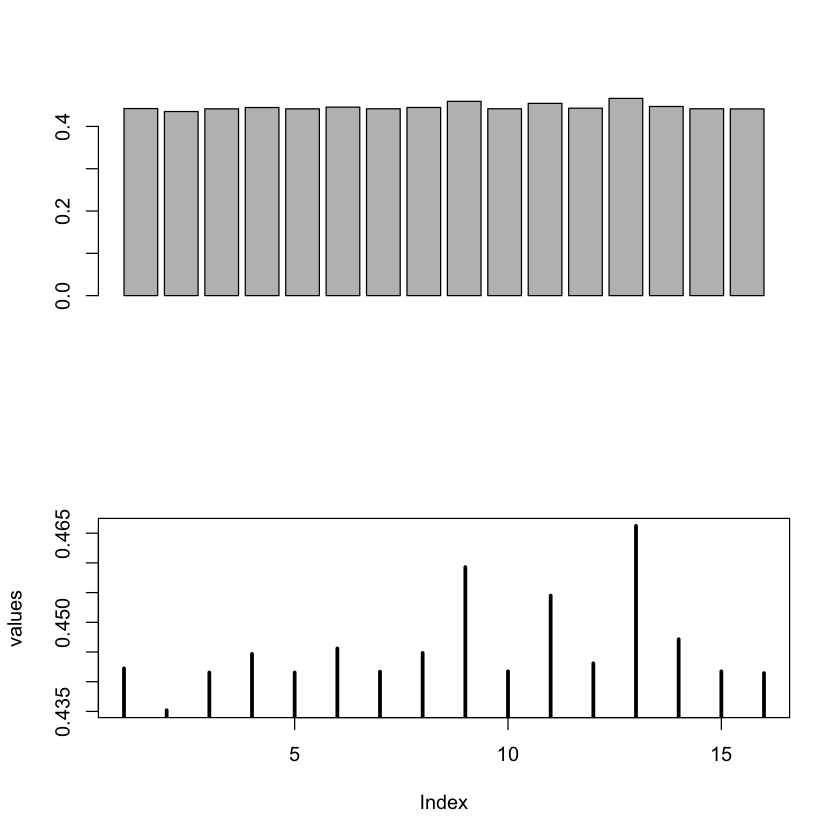

In [4]:
localHistogramRelease <- function(x, lower, upper, nbins=0, epsilon){ 
    # same as the integer histogram - local release on all values
	n <- length(x)
	if(nbins==0){
		lower <- floor(lower) # somewhat unnecessary
		upper <- ceiling(upper) # somewhat unnecessary
		bins <- lower:upper   
        nbins <- length(bins)
    }

    x.clipped <- clip(x=x, lower=lower, upper=upper)

	sensitivity <- 2
	scale <- sensitivity / epsilon

	sensitiveValue <- DPrelease <- rep(NA,nbins)
	for(i in 1:length(bins)){
		sensitiveValue[i] <- sum(x.clipped==bins[i])
		DPrelease[i] <- localRelease(sensitiveValue[i], values=c(0,1), epsilon=epsilon/sensitivity)
	}

	return(list(release=DPrelease, true=sensitiveValue, codebook=bins))
}


truefrac <- function(x, lower, upper){
	fractions <- hist(x, breaks=(lower:(upper+1)-0.5), plot=FALSE)$density
	return(fractions)
}


nboot <- 20000
data1 <- bootstrap(data, n=nboot)

## now you make it a one hot encoded thang - variable is education
out1 <- matrix(NA, nrow=nboot, ncol=16)
for(i in 1:nboot){
	out1[i,] <- localHistogramRelease(x=data1[i], lower=1, upper=16, epsilon=0.5)$release
}

values <- apply(out1,2,mean) # 2 refers to columns


par(mfcol=c(2,1))

barplot(values)
plot(values, type="h", lwd=3)



Zooming into a small range of values is a lot more informative in the second plot

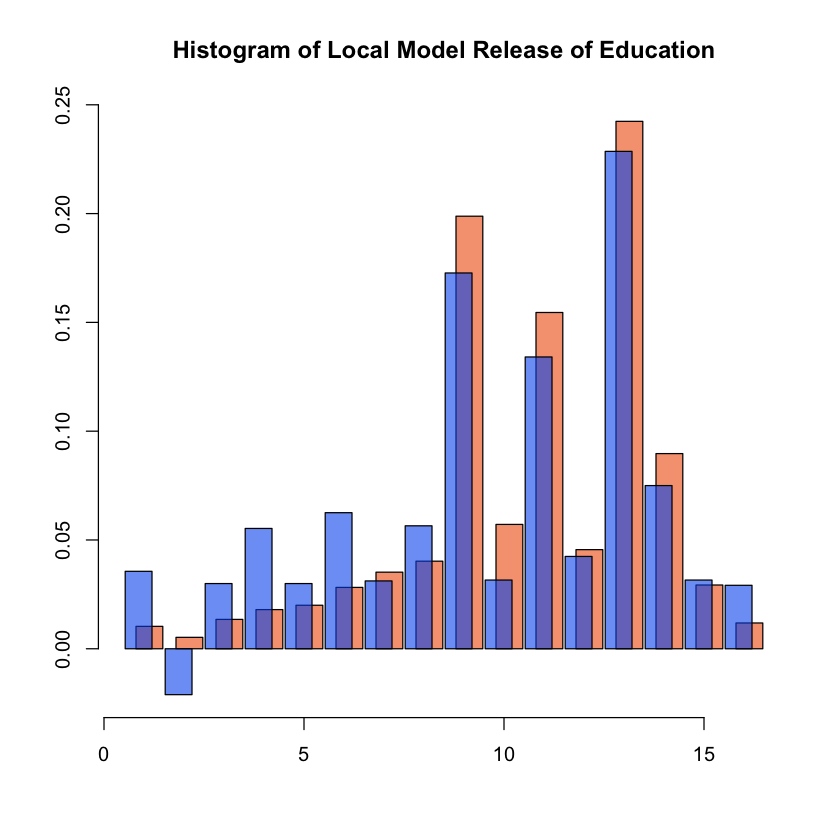

In [7]:
#Side-by-side histograms for Local Releases
showHistLocal <- function(DPrelease, true, codebook, main="Histogram"){

	semi.blue <- rgb(0,90,239,150,maxColorValue=255)          # Slightly transparent colors
	semi.red  <- rgb(239,90,0,150,maxColorValue=255)

	allylim <- c(min(c(DPrelease,true), na.rm = TRUE), max(c(DPrelease, true), na.rm = TRUE))
	granularity <- (max(codebook) - min(codebook))/(length(codebook)-1)

	allxlim <- c(min(codebook) - 0.5*granularity, max(codebook + 0.5*granularity))

    # Build empty plot
	plot.new()
	plot.window( xlim=allxlim, ylim=allylim)
	title(main = main)
	axis( side=1 )
	axis( side=2 )

	tiny <- granularity*0.03 # slight spacing between bars
	overlap <- granularity*0.2 # some small overlap between sensitive and DP values

	for(i in 1:length(codebook)){
		rect(xleft=codebook[i]-overlap, ybottom=0, xright=codebook[i]+0.5*granularity-tiny, ytop=true[i], col=semi.red)
		rect(xleft=codebook[i]-0.5*granularity+tiny, ybottom=0, xright=codebook[i]+overlap, ytop=DPrelease[i], col=semi.blue)
	}
}

values <- apply(out1,2,mean)
DPmeans <- correction01(values, epsilon=0.5, sensitivity = 2)
true <- truefrac(data1, lower=1, upper=16)

par(mfcol=c(1,1))
showHistLocal(DPrelease=DPmeans, true=true, codebook=1:16, main="Histogram of Local Model Release of Education")

## Actual libraries for hash functions

In [8]:
#install.packages("openssl")
library("openssl")
sha256(c("james","salil","james"), key="my_secret")

[1] "8d31dd75682405fb313880755c291df1e41aec7f6e508966f50ea87bb30e101c"
[2] "fd621f57d979866dbd10da6001a0b5184f374e7be2c4923104e2bedc013db4b2"
[3] "8d31dd75682405fb313880755c291df1e41aec7f6e508966f50ea87bb30e101c"

## Terrible Hash Functions

In [13]:
# use first letter of string
thash <- function(x){
	x <- tolower(x)
	hash<-NULL
	for(i in 1:length(x)){
		first.letter <- substr(x[i], start=1, stop=1) ## collisions when two words start with the same letter
		temp <- which(first.letter==letters)       # letters is smething in R
		hash <- c(hash, max(temp,0))         # max helps map nonletters to 0
	}
	return(hash)
}

# use last letter of string
thash2 <- function(x){
	x <- tolower(x)
	hash<-NULL
	for(i in 1:length(x)){
		last.letter <- substr(x[i], start=nchar(x[i]), stop=nchar(x[i]))
		temp <- which(last.letter==letters)      
		hash <- c(hash, max(temp,0))         # max helps map nonletters to 0
	}
	return(hash)
}

## Discover Species Names

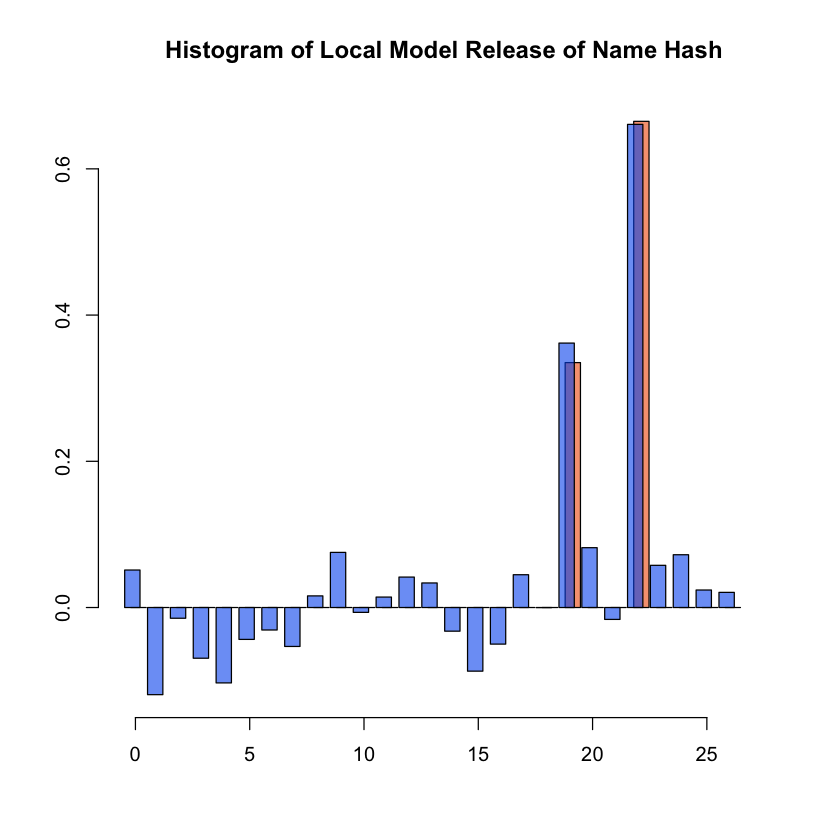

In [16]:
data("iris")

names <- bootstrap(iris$Species, n=5000) 

out2 <- out3 <- matrix(NA, nrow=length(names), ncol=27)

names.hash <- thash(names)
for(i in 1:length(names.hash)){
	out2[i,] <- localHistogramRelease(x=names.hash[i], lower=0, upper=26, epsilon=0.5)$release
}

names.hash2 <- thash2(names)
for(i in 1:length(names.hash)){
	out3[i,] <- localHistogramRelease(x=names.hash2[i], lower=0, upper=26, epsilon=0.5)$release
}

values <- apply(out2,2,mean)
DPmeans <- correction01(values, epsilon=0.5, sensitivity = 2)
true <- truefrac(names.hash, lower=0, upper=26)

showHistLocal(DPrelease=DPmeans, true=true, codebook=0:27, main="Histogram of Local Model Release of Name Hash")

## Show Client-SFP for string discovery 

In [36]:
clientSFP <- function(x, epsilon, myhash){ # can pass a function as an argument
	a <- localHistogramRelease(x = myhash(x), lower = 0, upper = 26, epsilon = epsilon/2 )$release # this will already account for 
	l <- ceiling(runif(1, min = 0 , max = 10)) # only allow words of length ten as apply does
            # could also do sample function
            # could also draw from a gaussian and convert to be between 0 and 10
	b <- substr(x,start=l,stop=l) # in apple implementation, take l to l+1 # if you report this back without being DP, that's not great
    b.DP <- localHistogramRelease(b, lower = 0, upper = 26, epsilon = epsilon/2)
	return(list(a=a, b=b, l=l))
}

x<- bootstrap(iris$Species, n=10000)
l <- rep(1,length(x))
b <- rep("a",length(x))
out4 <- matrix(NA, nrow=length(x), ncol=27)
myepsilon <- 2


for(i in 1:length(x)){
	release <- clientSFP(x[i], epsilon=myepsilon, myhash=thash2)
	out4[i,] <- release$a
	b[i] <- release$b
	l[i] <- release$l
}

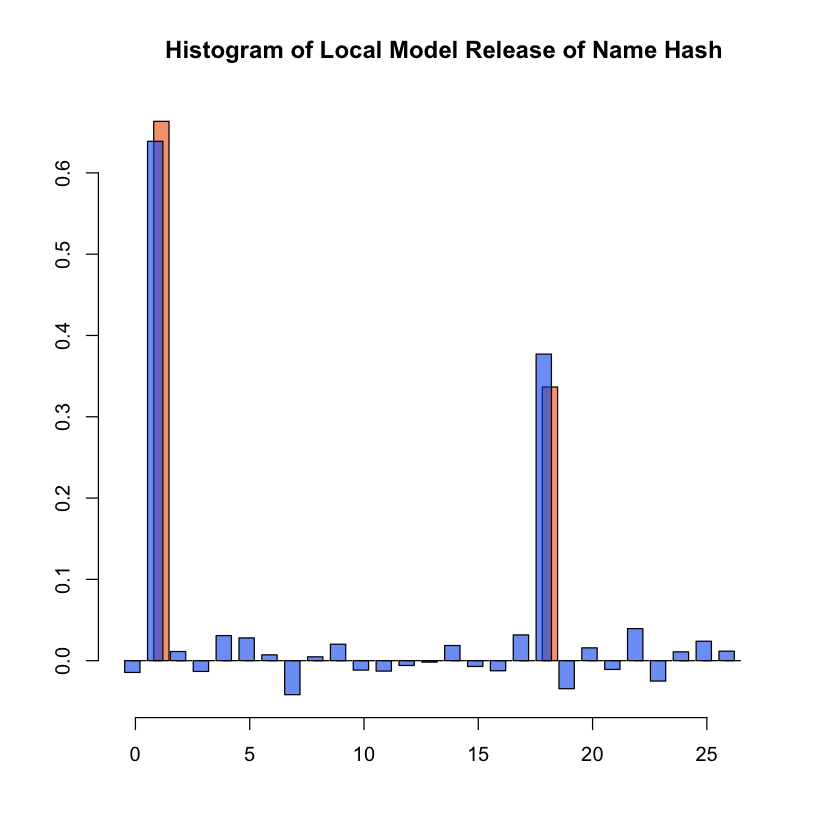

In [38]:
# Show identified hash

codebook<- 0:26
values <- apply(out4,2,mean)
DPmeans <- correction01(values, epsilon=myepsilon/2, sensitivity = 2)
true <- truefrac(thash2(x), lower=0, upper=26)

showHistLocal(DPrelease=DPmeans, true=true, codebook=0:27, main="Histogram of Local Model Release of Name Hash")

In [35]:
# Piece together puzzle

Threshold <- 0.1
discovered <- which(DPmeans>Threshold) 

cat("Actual Names: \n")
cat(paste(sort(unique(iris$Species)), "\n"))

for(j in 1:length(discovered)){
	flag <- out4[,discovered[j]] == 1
	temp.b <- b[flag]
	temp.l <- l[flag]
	t <- table(temp.b,temp.l)
	print(t)
	size <- ncol(t)
	word <- rep("",size)
	for(k in 1:ncol(t)){
		word[k]<-row.names(t)[which(t[,k]==max(t[,k]))][1]
	}
	print(word)
}

Actual Names: 
setosa 
 versicolor 
 virginica 
      temp.l
temp.b   1   2   3   4   5   6   7   8   9  10
         0   0   0   0   0   0 223 249 245 507
     a   0   0   0   0   0 233   0   0 265   0
     c   0   0   0   0   0  88   0 258   0   0
     e   0 323   0   0   0   0   0   0   0   0
     g   0   0   0 229   0   0   0   0   0   0
     i   0 245   0   0 339   0 217   0   0   0
     l   0   0   0   0   0   0   0  95   0   0
     n   0   0   0   0   0 242   0   0   0   0
     o   0   0   0 240   0   0  70   0  85   0
     r   0   0 340   0   0   0   0   0   0  74
     s 253   0   0  94 231   0   0   0   0   0
     t   0   0 246   0   0   0   0   0   0   0
     v 334   0   0   0   0   0   0   0   0   0
 [1] "v" "e" "r" "o" "i" "n" ""  "c" "a" "" 
      temp.l
temp.b   1   2   3   4   5   6   7   8   9  10
         0   0   0   0   0   0  78 103  90 182
     a   0   0   0   0   0  89   0   0  87   0
     c   0   0   0   0   0 217   0  98   0   0
     e   0 345   0   0   0   0   0 